In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
path = "/content/drive/MyDrive/Mall_Customers.xls"  # CHANGE THIS
df = pd.read_csv(path)

df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
print(df.info())
print(df.describe())

# Check missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [ ]:
df = df.dropna().reset_index(drop=True)


In [ ]:
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].values
X[:5]


array([[19, 15, 39],
       [21, 15, 81],
       [20, 16,  6],
       [23, 16, 77],
       [31, 17, 40]])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


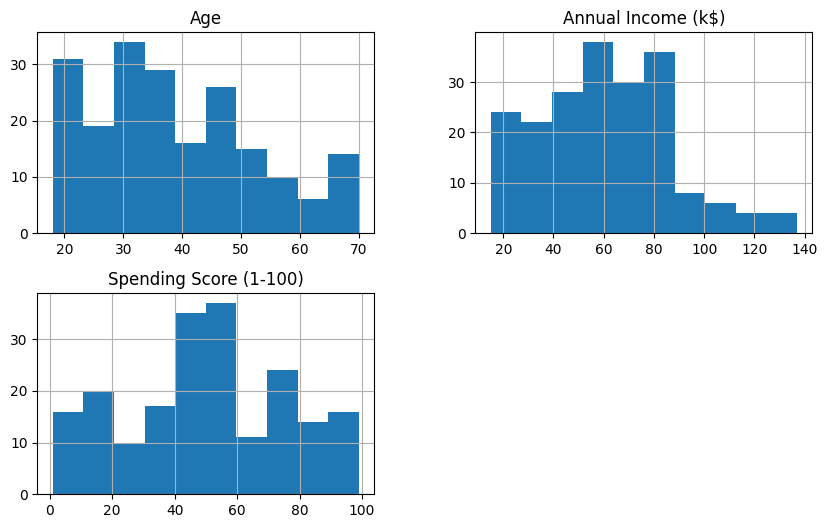

In [ ]:
df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].hist(figsize=(10,6))
plt.show()


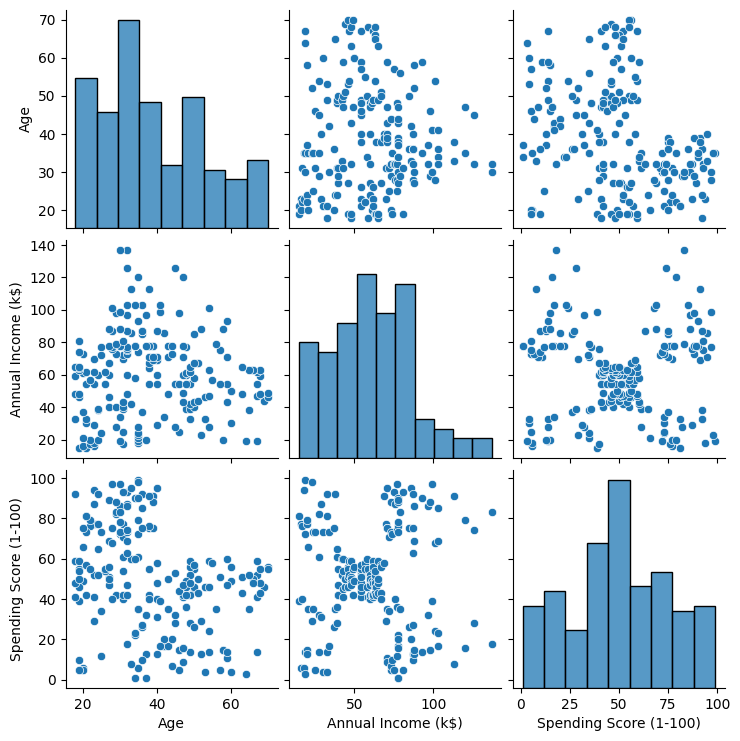

In [ ]:
sns.pairplot(df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
plt.show()


In [ ]:
def initialize_centroids_random(X, k, random_state=None):
    if random_state: np.random.seed(random_state)
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]


In [ ]:
def initialize_centroids_kmeans_plus(X, k, random_state=None):
    if random_state: np.random.seed(random_state)
    centroids = []

    # 1st centroid
    centroids.append(X[np.random.randint(len(X))])

    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
        prob = distances / distances.sum()
        chosen = np.random.choice(len(X), p=prob)
        centroids.append(X[chosen])

    return np.array(centroids)


In [ ]:
def assign_clusters(X, centroids):
    labels = []
    for x in X:
        dist = np.linalg.norm(x - centroids, axis=1)
        labels.append(np.argmin(dist))
    return np.array(labels)


In [ ]:
def update_centroids(X, labels, k):
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
    return new_centroids


In [ ]:
def kmeans(X, k, max_iters=100, tol=1e-4, init="random", random_state=None):

    if init == "kmeans++":
        centroids = initialize_centroids_kmeans_plus(X, k, random_state)
    else:
        centroids = initialize_centroids_random(X, k, random_state)

    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break

        centroids = new_centroids

    inertia = sum([np.linalg.norm(X[j] - centroids[labels[j]])**2 for j in range(len(X))])

    return centroids, labels, i+1, inertia


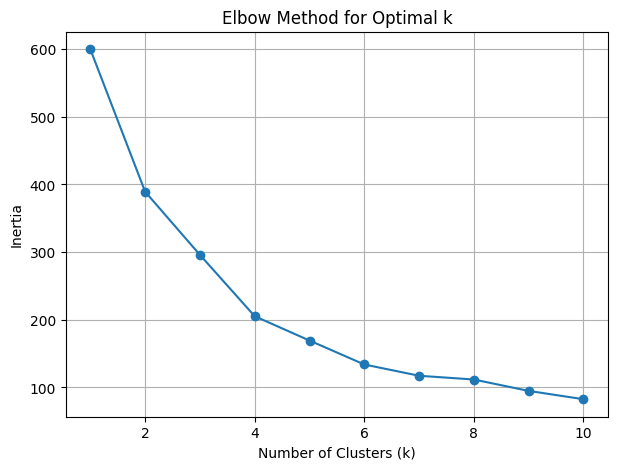

In [ ]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    _, _, _, inertia = kmeans(X_scaled, k, init="kmeans++")
    inertias.append(inertia)

plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


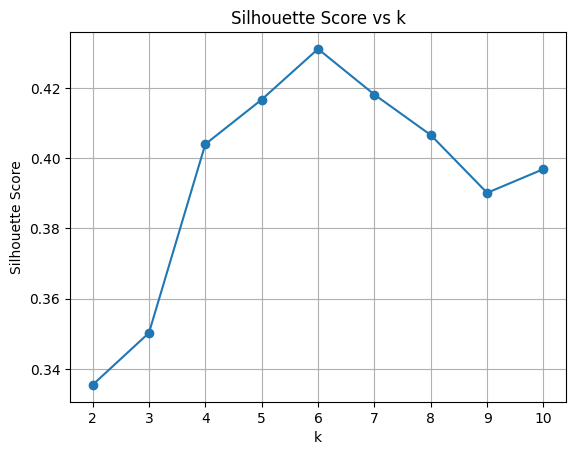

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 11):
    _, labels, _, _ = kmeans(X_scaled, k, init="kmeans++")
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()


In [ ]:
k = 5
centroids, labels, iters, inertia = kmeans(X_scaled, k, init="kmeans++")
print("Iterations:", iters)
print("Inertia:", inertia)
print("Centroids:\n", centroids)


Iterations: 11
Inertia: 169.89149793438568
Centroids:
 [[-0.42880597  0.97484722  1.21608539]
 [-0.93876351 -1.31473131  0.95680216]
 [ 1.17882975 -0.49388609 -0.32971553]
 [-0.86957306 -0.23851652 -0.36060916]
 [ 0.39737911  1.11508909 -1.23126963]]


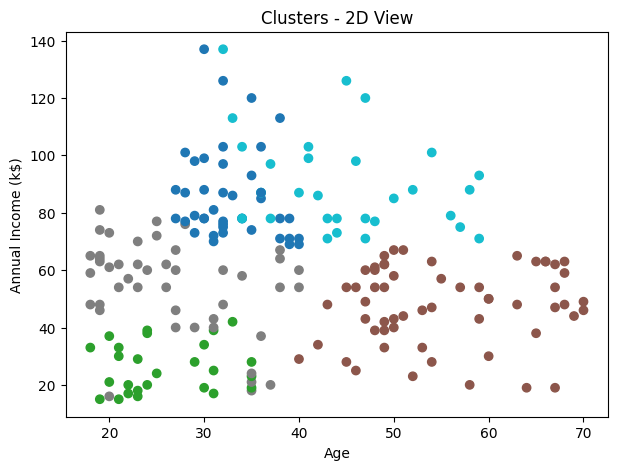

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10')
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.title("Clusters - 2D View")
plt.show()


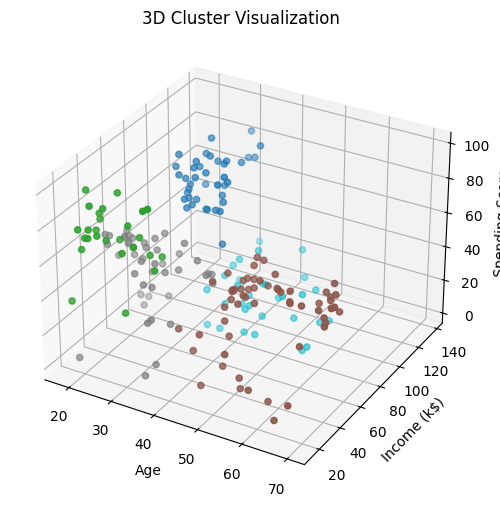

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap='tab10')
ax.set_xlabel("Age")
ax.set_ylabel("Income (k$)")
ax.set_zlabel("Spending Score")
plt.title("3D Cluster Visualization")
plt.show()


In [ ]:
df_clusters = df.copy()
df_clusters["Cluster"] = labels

df_clusters.groupby("Cluster").mean(numeric_only=True)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,161.025000,32.875000,86.100000,81.525000
1,23.461538,25.769231,26.115385,74.846154
2,68.775862,55.275862,47.620690,41.706897
3,86.377778,26.733333,54.311111,40.911111
4,166.870968,44.387097,89.774194,18.483871


In [ ]:
from sklearn.cluster import KMeans

sk = KMeans(n_clusters=k, random_state=42)
sk.fit(X_scaled)

print("SKLearn Inertia:", sk.inertia_)
print("SKLearn Iter:", sk.n_iter_)
print("Centroids:\n", sk.cluster_centers_)


SKLearn Inertia: 169.89149793438568
SKLearn Iter: 7
Centroids:
 [[ 1.17882975 -0.49388609 -0.32971553]
 [-0.42880597  0.97484722  1.21608539]
 [-0.93876351 -1.31473131  0.95680216]
 [-0.86957306 -0.23851652 -0.36060916]
 [ 0.39737911  1.11508909 -1.23126963]]
